## Importations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE, KMeansSMOTE, SVMSMOTE, ADASYN

from cuml.neighbors import NearestNeighbors
from cuml.svm import SVC as cumlSVC

from sklearn import feature_selection
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing

from sklearn import ensemble
from sklearn import svm
from sklearn import tree

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_halving_search_cv

from xgboost import XGBClassifier, DMatrix, train

from utils import plot_confusion_matrix, print_feature_importance

## Data Loading

The original MaFaulDa was sampled using 50 kHz 24-bit 8-channel, but this work will use audio data only, which is the 8th channel only. This work uses 24 kHz 16-bit PCM 1-channel (mono) with a normalization of -6 dBFS. So the dataset was completely converted to the mentioned specifications using SoX.

The segmentation used segment duration of 500 ms and overlap duration of 20 ms. Then, the featured extraction produced a CSV file with several columns of features, a column of class label, a column of class number, and a column of filename.

The following cell imports the data from the CSV, shows its general information, shows a few of its samples, and shows the amount of samples per class.

In [2]:
# loading data
CSV_FILE = "new_mafaulda_24khz_500ms_20ms_40-mfcc.csv"
df = pd.read_csv(CSV_FILE)

# adding source column to the dataframe
df["source"] = "original"

# show dataframe info
df.info()

# show dataframe head
df.head()

# print number of samples per class
df["label"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19510 entries, 0 to 19509
Columns: 147 entries, mean to source
dtypes: float64(143), int64(1), object(3)
memory usage: 21.9+ MB


underhang                  5580
overhang                   5130
imbalance                  3330
vertical_misalignment      3010
horizontal_misalignment    1970
normal                      490
Name: label, dtype: int64

Now, let's check if there are any NaN values, and, if necessary, we'll remove the columns (features) with at least one NaN value.

In [3]:
# count the number of NaN values in each column
total_nan = df.isna().sum().sum()

# count the number of rows with at least one NaN value
rows_nan = df.isna().any(axis=1).sum()

# count the number of columns with at least one NaN value
columns_nan = df.isna().any().sum()

# create a copy of dataframe without columns with at least NaN
df_without_nan = df.dropna(axis=1)

print("NaN values in DataFrame:", total_nan)
print("Rows with at least one NaN value:", rows_nan)
print("Columns with at least one NaN value:", columns_nan)

NaN values in DataFrame: 0
Rows with at least one NaN value: 0
Columns with at least one NaN value: 0


Now, we get separate variables for features and classes. Also, we create a label encoder for preprocessing and use it to get classes numbers. Then, we get features (X) and class numbers (y) arrays.

In [4]:
# extract the features and the class
features = df_without_nan.drop(columns=["filename", "label", "class", "source"])
class_column = df_without_nan["class"]

# encode class column if necessary
label_encoder = preprocessing.LabelEncoder()
class_column_encoded = label_encoder.fit_transform(class_column)

# set X and y values
X = features.values
y = class_column_encoded.copy()

Now, we apply a data augmentation to the dataset of features and classes.

We also add the "source" column, because it is used to be sure that there are no samples from the same file used both in training and testing steps.

Then, we check the amount of samples per class generated by the data augmentation process.

In [5]:
# apply ADASYN (oversampling minority class) to the dataset
X_resampled, y_resampled = ADASYN(sampling_strategy="minority", random_state=42).fit_resample(X, y)

# create a new dataframe with the new samples
new_df = pd.DataFrame(X_resampled, columns=features.columns)
new_df["class"] = label_encoder.inverse_transform(y_resampled)
new_df["source"] = "generated"

# add label column to the dataframe of new samples
new_df.loc[new_df["class"] == 0, "label"] = "normal"
new_df.loc[new_df["class"] == 1, "label"] = "horizontal_misalignment"
new_df.loc[new_df["class"] == 2, "label"] = "vertical_misalignment"
new_df.loc[new_df["class"] == 3, "label"] = "imbalance"
new_df.loc[new_df["class"] == 4, "label"] = "overhang"
new_df.loc[new_df["class"] == 5, "label"] = "underhang"

# add filename column to the new dataframe
original_filenames = df["filename"].values
new_filenames = [f"generated_{i}.wav" for i in range(len(original_filenames), len(original_filenames) + len(new_df))]
new_df["filename"] = new_filenames

# print the amount of new samples generated per class
new_df["label"].value_counts()

underhang                  5580
normal                     5543
overhang                   5130
imbalance                  3330
vertical_misalignment      3010
horizontal_misalignment    1970
Name: label, dtype: int64

Concatenate both original dataframe and new dataframe created with generated samples to create an augmented dataframe.

In [6]:
# concatenate the original dataframe with the new dataframe
df_resampled = pd.concat([df, new_df], ignore_index=True)

# show dataframe info
df_resampled.info()

# print number of samples per class
df_resampled["label"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44073 entries, 0 to 44072
Columns: 147 entries, mean to source
dtypes: float64(143), int64(1), object(3)
memory usage: 49.4+ MB


underhang                  11160
overhang                   10260
imbalance                   6660
normal                      6033
vertical_misalignment       6020
horizontal_misalignment     3940
Name: label, dtype: int64

Saves the list of features in the dataframe and the labels to be used later.

In [7]:
FEATURES_LST    = [column for column in df_resampled.columns if column not in ["filename", "class", "label", "source"]]
labels          = list(df_resampled["label"].unique())

Splitting the data into train and test sets using unique files only, which means that there will be no samples in both train and test sets that came from the same file. For example, let us say that the file "audio.wav" produced 10 segments. Each segment was used to extract features, so there will be 10 entries at the dataframe that came from the very same audio file. Considering that those 10 entries came from the same file, we can say that, necessarily, all 10 samples came from the very same class and, more than that, they come from the very same scenario. So, if some of the 10 entries were used to train and the others were used to test, it would be considered some kind of cheating. Then, it would be recommended to used all those entries in one set only, that could be all of them used to train or all of them used to test. So, this is the reason why we have to use the "unique" function to the "filename" column of "df_resampled" dataframe.

In [8]:
# splitting the data into training and test sets
TEST_SIZE       = 0.20
RANDOM_STATE    = 42

# X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

unique_files = df_resampled["filename"].unique()

train_files, test_files = model_selection.train_test_split(unique_files, test_size=TEST_SIZE, random_state=RANDOM_STATE)

train_df    = df_resampled[df_resampled['filename'].isin(train_files)]
test_df     = df_resampled[df_resampled['filename'].isin(test_files)]

print(f"Train files:    {len(train_files)}  ({len(train_df) / len(df_resampled) * 100:.2f}%)")
print(f"Test files:     {len(test_files)}   ({len(test_df) / len(df_resampled) * 100:.2f}%)")
print(f"Train samples:  {len(train_df)}     ({len(train_df) / len(df_resampled) * 100:.2f}%)")
print(f"Test samples:   {len(test_df)}      ({len(test_df) / len(df_resampled) * 100:.2f}%)")

Train files:    21211  (80.39%)
Test files:     5303   (19.61%)
Train samples:  35431     (80.39%)
Test samples:   8642      (19.61%)


Getting features and classes for both train and test steps.

In [9]:
X_train = train_df[FEATURES_LST].values
y_train = train_df["class"].values

X_test  = test_df[FEATURES_LST].values
y_test  = test_df["class"].values

Standardize data for both train and test steps.

In [10]:
scaler = preprocessing.RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

Creating cross-validation object, which is a stratified K-Fold with 5 splits and shuffle.

In [11]:
# defining the cross-validation strategy
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

Adapting data to be used as DMatrix for GPU processing during XGBoost Classifier training.

In [12]:
# create an imputer
my_imputer = SimpleImputer()

# impute missing values
X_train = my_imputer.fit_transform(X_train)
X_test  = my_imputer.transform(X_test)

# Convert the datasets into DMatrix
dtrain  = DMatrix(X_train, label=y_train)
dtest   = DMatrix(X_test, label=y_test)

Training the Model.

Fold 1 accuracy: 0.9709
Fold 2 accuracy: 0.9746
Fold 3 accuracy: 0.9780
Fold 4 accuracy: 0.9781
Fold 5 accuracy: 0.9766

Mean accuracy: 0.9756 ± 0.0027


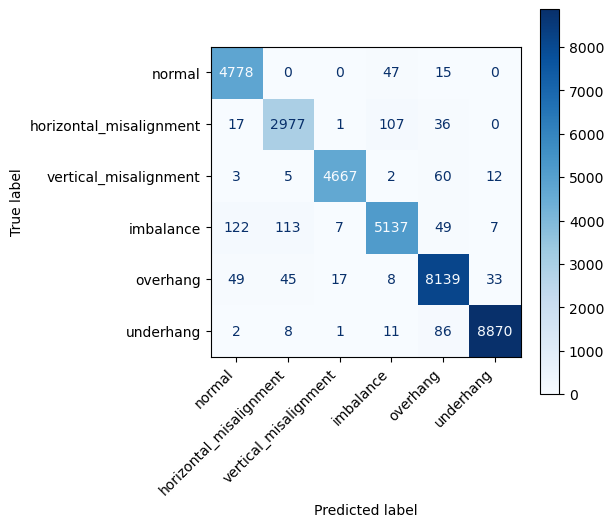

In [13]:
NUM_BOOST_ROUND = 40

# define parameters for the XGBoost model
params = {
    'max_depth':                5,
    'learning_rate':            0.1,
    'subsample':                0.7,
    'colsample_bytree':         0.8,
    'colsample_bylevel':        0.8,
    'objective':                'multi:softprob',
    'eval_metric':              'mlogloss',
    'random_state':             42,
    'tree_method':              'hist',
    'device':                   'cuda',
    'num_class':                len(np.unique(y_train))
}

# Lists to store accuracy of each fold and predictions
accuracy_list = []
y_test_all = []
y_pred_all = []

# Perform Stratified K-Fold Cross Validation
fold_number = 1
for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    
    # Convert the datasets into DMatrix
    dtrain = DMatrix(X_train_fold, label=y_train_fold)
    dtest = DMatrix(X_test_fold, label=y_test_fold)
    
    # Train the model
    evals = [(dtest, 'eval'), (dtrain, 'train')]
    bst = train(params, dtrain, num_boost_round=NUM_BOOST_ROUND, evals=evals, early_stopping_rounds=10, verbose_eval=False)
    
    # Make predictions
    y_pred_proba = bst.predict(dtest)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Calculate accuracy
    accuracy = metrics.accuracy_score(y_test_fold, y_pred)
    accuracy_list.append(accuracy)
    
    # Store predictions for confusion matrix
    y_test_all.extend(y_test_fold)
    y_pred_all.extend(y_pred)
    
    print(f'Fold {fold_number} accuracy: {accuracy:.4f}')
    
    fold_number += 1

# Calculate the mean accuracy
mean_accuracy = np.mean(accuracy_list)
print(f"\nMean accuracy: {mean_accuracy:.4f} ± {np.std(accuracy_list):.4f}")

# Ploting Confusion Matrix
cm = metrics.confusion_matrix(y_test_all, y_pred_all)
class_names = list(df_resampled["label"].unique())
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()

Plotting the feature importance.

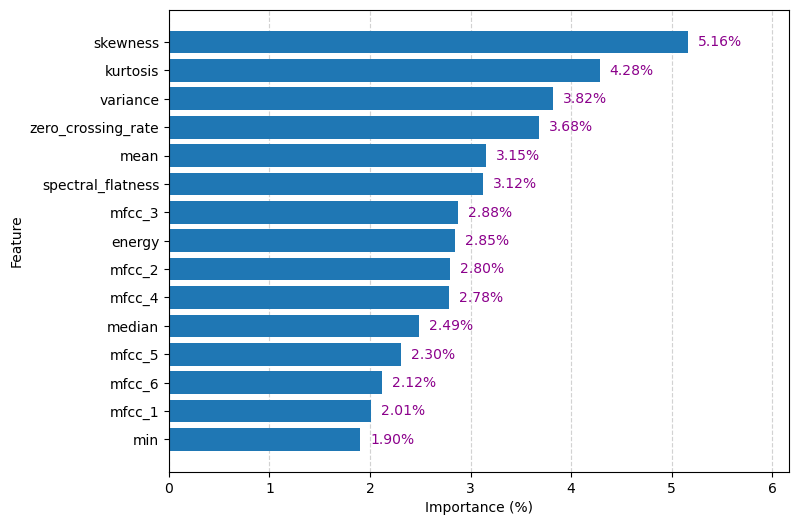

In [14]:
# Get feature names
feature_names = df.columns.drop(['class', 'label', 'filename', 'source'])

# Get the feature importances from the last trained model
feature_importances = bst.get_score(importance_type='weight')

# Map the feature importances to the original feature names
importance_df = pd.DataFrame.from_dict(feature_importances, orient='index', columns=['importance'])
importance_df.index = [feature_names[int(feat[1:])] for feat in importance_df.index]  # Convert 'f0', 'f1', ... to feature names
importance_df.index.name = 'feature'
importance_df.reset_index(inplace=True)

# Normalize importances to sum up to 1 and convert to percentage
importance_df['importance'] /= importance_df['importance'].sum()
importance_df['importance_percent'] = importance_df['importance'] * 100

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Select the top 15 features
top_features = importance_df.head(15)

# Plot the feature importances as percentages
plt.figure(figsize=(8, 6))
bars = plt.barh(top_features['feature'], top_features['importance_percent'], zorder=2)
plt.grid(linestyle='--', axis='x', linewidth=0.85, color='gray', alpha=0.35, zorder=0)
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top

# Add the importance values to the right of each bar
for bar, value in zip(bars, top_features['importance_percent']):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{value:.2f}%', va='center', color='darkmagenta')

# Set the xlim to ensure the text stays within the plot
plt.xlim(0, top_features['importance_percent'].max() + 1)  # Add minimal padding to the xlim

plt.show()